In [35]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Lambda
import matplotlib.pyplot as plt
import numpy as np
from frozendict import frozendict
from msdm.domains import GridWorld
from msdm.algorithms import ValueIteration
from msdm.core.problemclasses.mdp import TabularPolicy
from msdm.core.distributions import DictDistribution


# Data Production

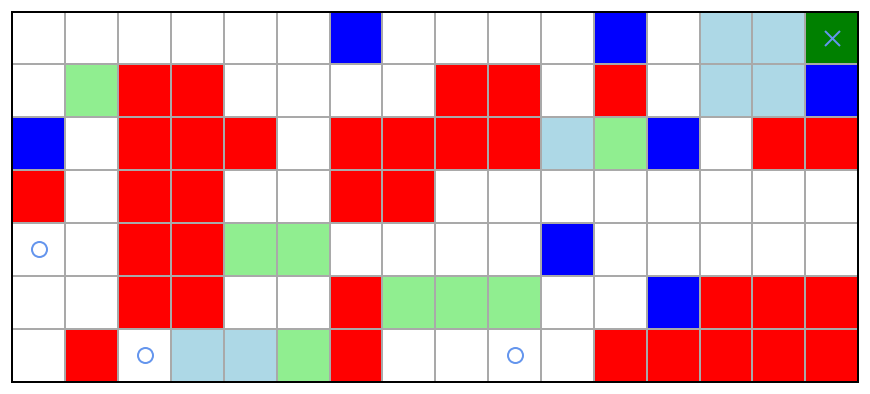

In [36]:
# Create a gridworld
gw = GridWorld(
    tile_array=[
        "......c....c.bbg",
        ".axx....xx.x.bbc",
        "c.xxx.xxxxbac.xx",
        "x.xx..xx........",
        "s.xxaa....c.....",
        "..xx..xaaa..cxxx",
        ".xsbbax..s.xxxxx",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=0.99,
)
featurecolors = {
    'g': 'green',
    'x': 'red',
    'c': 'blue',
    '.': 'white',
    'a': 'lightgreen',
    'b': 'lightblue'
}
gw.plot(featurecolors=featurecolors)


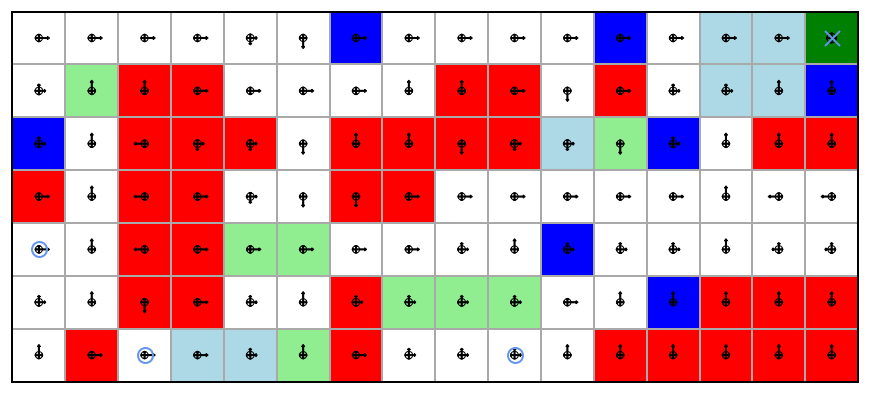

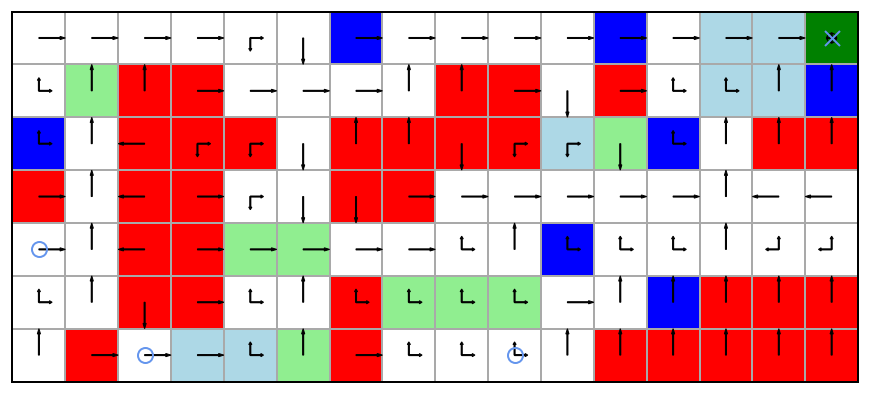

In [110]:
# Expert has a optimal policy
vi_res = ValueIteration().plan_on(gw)
# Use a softmax policy for exploration so the trajectories are not always the same (still chooses the best action with the most probability though). Higher inverse_temperature means more deterministic
softmax_policy = TabularPolicy.from_q_matrix(gw.state_list, gw.action_list, q=vi_res._qvaluemat,inverse_temperature=float(100))

gw.plot(featurecolors=featurecolors).plot_policy(softmax_policy)
gw.plot(featurecolors=featurecolors).plot_policy(vi_res.policy)


In [38]:
print(vi_res.policy.evaluate_on(gw).initial_value)

-8.850520981705522


In [40]:
# Generate num_iters of trajectories
train_iters = 100000
test_iters = 500
trajectories = []
test_trajectories = []

for _ in range(train_iters):
  # both will start at one of the labelled starting points
  # trajectories.append(vi_res.policy.run_on(gw))
  trajectories.append(softmax_policy.run_on(gw))

# softmax policy allows for unseen trajectories which qualify for testing trajectories
for _ in range(test_iters):
  # test_trajectories.append(vi_res.policy.run_on(gw))
  test_trajectories.append(softmax_policy.run_on(gw))


In [41]:
# Integer to Action Dictionary
# int_to_action = {0: "up", 1: "down", 2: "right", 3: "left", 4: "stay"}

identifier_to_int={
    'g': 0,
    'x': 1,
    'c': 2,
    'a': 3,
    'b': 4,
    's': 5,
}

# returns a label 0, 1, 2, 3, or 4
def convertAction(action):
  dy = action.get('dy')
  dx = action.get('dx')
  if dy == 1:
    return 0
  elif dy == -1:
    return 1
  elif dx == 1:
    return 2
  elif dx == -1:
    return 3
  else:
    return 4

def convertColor(state):
  color_identifier = gw.location_features.get(state)
  if color_identifier is None:
    return 6
  else:
    return identifier_to_int[color_identifier]

# state feature vector: gets the features of a state which are just (x, y) coordinates
# parameter state in form (frozendict({'x': 9, 'y': 0})
# returns a 2D array [[x, y, state_identifier]]
def getStateFeature(state):
  return [[state.get('x'), state.get('y'), convertColor(state)]]

# get state features (x-coord, y-coord, state_identifier) and actions for each state in each trajectory
# prepping the training data (X_train and Y_train) for supervised learning algorithm
# return numpy arrays, all_features and all_actions.
# all_features: a 2D array where each row is a state (a sample) and column 0 is x-coordinate, column 1 is y-coordinate, column
# 2 is state identifier
# all_actions: a 1D array where each row corresponds to the action to take in the same row of all_features
def getFeaturesActions(trajectories):
  all_features = []  # converting all states to features for training data
  all_actions = []  # storing the actions taken in each state in the same order
  for trajectory in trajectories:
    # assuming trajectory is an array of tuples
    state_traj = trajectory.state_traj  # grab state trajectory
    action_traj = trajectory.action_traj  # grab action trajectory
    for state in state_traj:
      # states are format (frozendict({'x': 9, 'y': 0})
      # convert states to (x, y, state_identifier)
      state_feature = getStateFeature(state)
      all_features.append(state_feature)
    for action in action_traj:
      # actions are format frozendict({'dy': 1, 'dx': 0})
      # convert action to single dimension (an integer)
      conv_action = convertAction(action)
      all_actions.append(conv_action)

  # all_features must be a 2d array of floats and all_actions must be an array of integers
  return np.array(all_features, dtype='f'), np.array(all_actions)

# either pass in the (x, y, state_identifier) features array and action array or process them in here by passing in the trajectories
class StatesActionsDataset(Dataset):
  def __init__(self, trajectories, transform=None, target_transform=None):
    self.state_features, self.actions = getFeaturesActions(trajectories=trajectories)
    self.transform = transform
    self.target_transform = target_transform  

  def __len__(self):
    return len(self.actions)

  def __getitem__(self, idx):
    state_feature = self.state_features[idx]
    # state_feature = self.state_features[0][idx]
    action = self.actions[idx]
    if self.transform:
        state_feature = self.transform(state_feature)
    if self.target_transform:
        action = self.target_transform(action)
    return state_feature, action


# Data Prepping

In [42]:
# Convert our numpy 2d array to a tensor for training
# do I need to convert the labels to a tensor? yes, does it for us in Lambda (target_transform)
class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""

  def __call__(self, sample):
    return torch.from_numpy(sample)


In [43]:
# Load our training and testing dataset
# train_dataset = StatesActionsDataset(trajectories, transform=ToTensor(), target_transform=Lambda(lambda y: torch.zeros(
#   5, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)))

# test_dataset = StatesActionsDataset(test_trajectories, transform=ToTensor(), target_transform=Lambda(lambda y: torch.zeros(
#     5, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)))

# Without making y a 1-hot vector
train_dataset = StatesActionsDataset(trajectories, transform=ToTensor())

test_dataset = StatesActionsDataset(test_trajectories, transform=ToTensor())


In [44]:
### Wrap Dataloader around our Dataset

batch_size = 128
# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# need to create test data
# don't shuffle test data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
  print("Shape of X [Batch_size, Num_coordinates]: ", X.shape, X.dtype)
  print("Shape of y: ", y.shape, y.dtype)
  break


Shape of X [Batch_size, Num_coordinates]:  torch.Size([128, 1, 3]) torch.float32
Shape of y:  torch.Size([128]) torch.int64


In [45]:
#### Need to create a ML model, train, classify, and evaluate test loss

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class ActionClassifier(nn.Module):
  def __init__(self):
    super(ActionClassifier, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv1d(1, 16, 3, padding=1),
      nn.BatchNorm1d(16),
      nn.ReLU()
    )
    self.conv2 = nn.Sequential(
      nn.Conv1d(16, 32, 3, padding=1),
      nn.BatchNorm1d(32),
      nn.ReLU()
    )
    self.conv3 = nn.Sequential(
      nn.Conv1d(32, 64, 3, stride=2, padding=1),
      nn.BatchNorm1d(64),
      nn.ReLU()
    )
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 5),
    )
    # don't use softmax bc nn.CrossEntropyLoss takes unnormalized outputs
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x_conv1 = self.conv1(x)
    x_conv2 = self.conv2(x_conv1)
    x_conv3 = self.conv3(x_conv2)
    x_flat = self.flatten(x_conv3)
    logits = self.linear_relu_stack(x_flat)
    probabilities = self.softmax(logits)
    return probabilities


model = ActionClassifier().to(device)
print(model)


Using cpu device
ActionClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
  (softmax): Softmax(dim=1)
)


In [46]:
# so pred doesn't have a grad_fn attached to it
with torch.no_grad():
  for s in gw.state_list:
    state_feature = torch.from_numpy(np.array([getStateFeature(s)], dtype='f'))
    pred = model(state_feature)[0]
    break

In [47]:
# Use Cross Entropy Loss for classification
loss_fn = nn.CrossEntropyLoss()

# better optimizer with a scheduler to decrease learning rate by 0.1 at indicated steps
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 4, 7, 9])

In [48]:
# Train the model
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 20000 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Test the model
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      
      # use this when y is a 1-hot vector
      # correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

      # use this when y is just a scalar label
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [49]:
# Train model for 10 epochs
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    print()
    test(test_dataloader, model, loss_fn)
    scheduler.step()
print("Done!")


Epoch 1
-------------------------------
loss: 1.610367  [    0/17264978]
loss: 1.574977  [2560000/17264978]
loss: 1.594681  [5120000/17264978]
loss: 1.578597  [7680000/17264978]
loss: 1.566442  [10240000/17264978]
loss: 1.601778  [12800000/17264978]
loss: 1.581019  [15360000/17264978]

Test Error: 
 Accuracy: 28.2%, Avg loss: 1.582516 

Epoch 2
-------------------------------
loss: 1.598619  [    0/17264978]
loss: 1.548182  [2560000/17264978]
loss: 1.599456  [5120000/17264978]
loss: 1.596705  [7680000/17264978]
loss: 1.615883  [10240000/17264978]
loss: 1.598312  [12800000/17264978]
loss: 1.562950  [15360000/17264978]

Test Error: 
 Accuracy: 27.9%, Avg loss: 1.585385 

Epoch 3
-------------------------------
loss: 1.591425  [    0/17264978]
loss: 1.592362  [2560000/17264978]
loss: 1.583951  [5120000/17264978]
loss: 1.589888  [7680000/17264978]
loss: 1.655005  [10240000/17264978]
loss: 1.567400  [12800000/17264978]
loss: 1.585907  [15360000/17264978]

Test Error: 
 Accuracy: 28.7%, Avg 

In [64]:
# Loading the saved model
model_5 = ActionClassifier().to(device)
model_5.load_state_dict(torch.load(
    "/Users/SamLiang/Documents/Princeton/Classes/Junior Semester 1/Independent Work/Supervised Learning Policy/Model 5/model_5.pt"))
model_5.eval()


ActionClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
  (softmax): Softmax(dim=1)
)

-6735.2546021062

-6700.053703955326


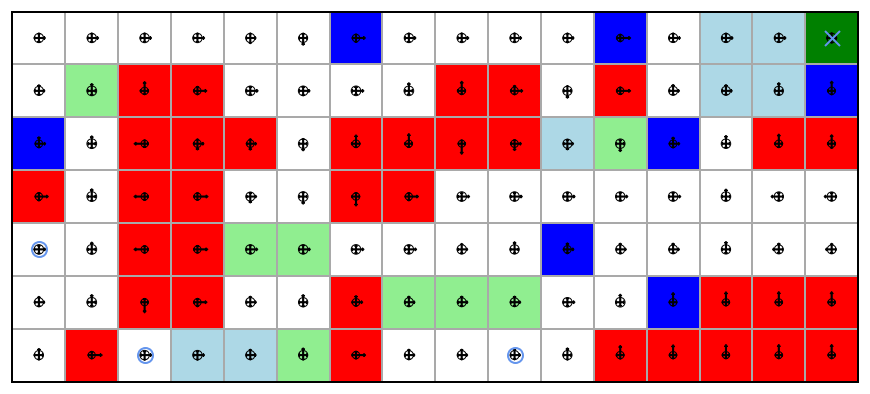

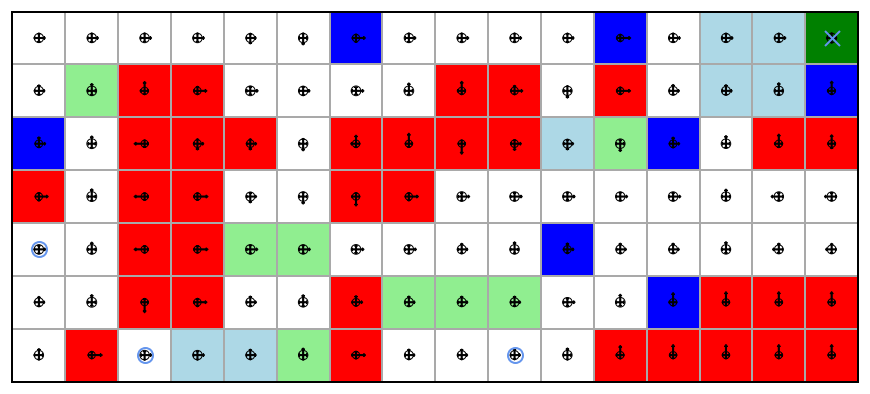

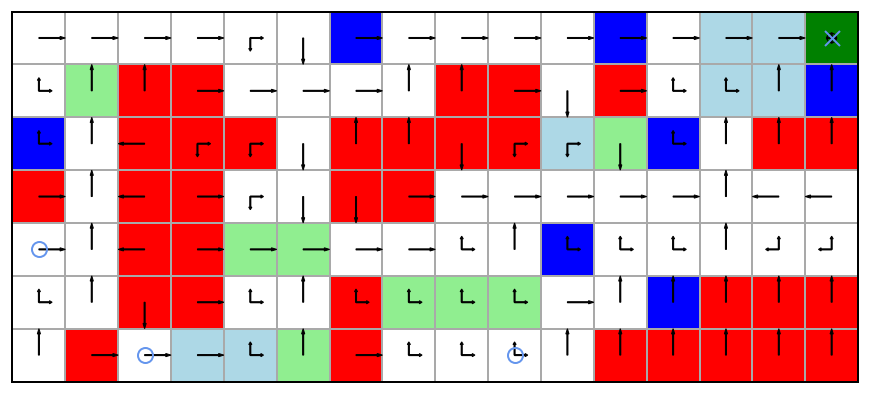

In [69]:
policy = {}
# int_to_action = {0: "up", 1: "down", 2: "right", 3: "left", 4: "stay"}
int_to_action = {0: frozendict(dx=0, dy=1), 1: frozendict(
    dx=0, dy=-1), 2: frozendict(dx=1, dy=0), 3: frozendict(dx=-1, dy=0), 4: frozendict(dx=0, dy=0)}

# softmax_fn = nn.Softmax(dim=1)

# so pred doesn't have a grad_fn attached to it
with torch.no_grad():
  for s in gw.state_list:
    state_feature = torch.from_numpy(np.array([getStateFeature(s)], dtype='f'))
    pred = model(state_feature)[0]
    # pred = model_5(state_feature)
    # probs = softmax_fn(pred)[0]
    policy[s] = {}
    # for each action in each state, grab from the "pred" result the probability of taking this action in this state and add that to the dictionary policy which is a dictionary with states as keys and a dictionary of "action: prob of taking this action in this state" as values
    for a_i, prob in enumerate(pred):
      policy[s][int_to_action[a_i]] = prob.item()

# to turn policy into an actual policy object that we can call the MSDM functions on
policy = TabularPolicy({s: DictDistribution(ap) for s, ap in policy.items()})
gw.plot(featurecolors=featurecolors).plot_policy(policy)
gw.plot(featurecolors=featurecolors).plot_policy(softmax_policy)
gw.plot(featurecolors=featurecolors).plot_policy(vi_res.policy)
print(policy.evaluate_on(gw).initial_value)
print()
print(softmax_policy.evaluate_on(gw).initial_value)

In [51]:
# Save the model to PATH
# PATH = "/Users/SamLiang/Documents/Princeton/Classes/Junior Semester 1/Independent Work/Supervised Learning Policy/Model 6/model_6.pt"
# torch.save(model.state_dict(), PATH)


In [ ]:
# Loading the saved model
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()